In [ ]:
from time import time
import matplotlib.pyplot as plt

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform

# lets use a 2 step algo
Eigenfaces is an approach where we PCA images of people's faces and use that transformed dimensions instead of the original pixel inputs

Lets get some faces...

In [ ]:
lfw_people = fetch_lfw_people(min_faces_per_person=55, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1403
n_features: 1850
n_classes: 9


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

How much of the variance of the pixels across images is encoded in the first 150 dimensions?

Extracting the top 150 eigenfaces from 1052 faces
done in 0.062s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.011s


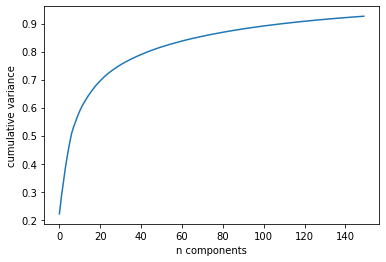

In [ ]:
n_components = 150

print(
    "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
)
t0 = time()
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance');


Grid search!

In [ ]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
    "C": loguniform(1e-2, 1e4),
    "gamma": loguniform(1e-5, 1e-1),
}

clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=25
)

clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


Fitting the classifier to the training set
done in 16.615s
Best estimator found by grid search:
SVC(C=16.392919134365087, class_weight='balanced', gamma=4.1941946384456144e-05)


Lets visualize how the predications

Predicting people's names on the test set
done in 0.056s
                   precision    recall  f1-score   support

     Ariel Sharon       0.71      0.75      0.73        20
     Colin Powell       0.85      0.82      0.83        71
  Donald Rumsfeld       0.54      0.62      0.58        21
    George W Bush       0.87      0.84      0.85       134
Gerhard Schroeder       0.65      0.71      0.68        21
      Hugo Chavez       0.78      0.82      0.80        22
    Jean Chretien       0.58      0.64      0.61        11
Junichiro Koizumi       0.95      0.82      0.88        22
       Tony Blair       0.81      0.90      0.85        29

         accuracy                           0.80       351
        macro avg       0.75      0.77      0.76       351
     weighted avg       0.81      0.80      0.81       351



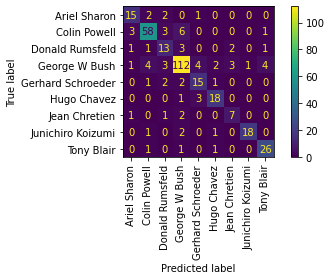

In [ ]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()